In [1]:
# !pip uninstall torch torchvision torchaudio torchtext torchdata -y
# !pip install torch torchvision

In [2]:
#import torch, torchvision

# print(torch.__version__)
# print(torchvision.__version__)

Version that work:

- 2.1.2+cu121

- 0.16.2+cu121

In [5]:
%pip install pandas
%pip install torchinfo torchsummary matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/160.8 kB ? eta -:--:--
     --------------------------------- ---- 143.4/160.8 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 160.8/160.8 kB 1.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.6 MB 4.1 MB/s eta 0:00:02
   - -------------------------------------- 0.2/7.6 MB 2.9 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/7.6 MB 3.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/7.6 MB 5.0 MB/s eta 0:00:02
   -------- ------------------------------- 1.7/7.6 MB 7.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.8/7.6 MB 10.1 MB/s eta 0:00:01
   -------------------- ------------------- 4

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import copy
import time
import os
import shutil

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary as info_summary
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms, models

# from google.colab import drive

In [8]:
# drive.mount("/content/drive")

In [9]:
# copy the data folder to the local disk for efficiency
# shutil.copytree("/content/drive/MyDrive/data", "/content/data")

### Loading data

In [10]:
def create_validation_set(train_data, train_percentage, test_transform):

  # Split train data into train and validation sets
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = torch.utils.data.random_split(train_data, [num_train_examples, num_valid_examples])

  # print(f"Number training examples: {len(train_data)}")
  # print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transform

  return train_data, valid_data

In [12]:
# create datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
])

# train_dataset = datasets.ImageFolder(root='/content/data/Final Training Data', transform=train_transform)
train_dataset = datasets.ImageFolder(root='Data/Final Training Data', transform=train_transform)
train_dataset, valid_dataset = create_validation_set(train_dataset, 0.8, test_transform)
# test_dataset = datasets.ImageFolder(root='/content/data/grape_dataset/test', transform=test_transform)
test_dataset = datasets.ImageFolder(root='Data/archive/grape_dataset/test', transform=test_transform)

# used to plot prediciton errors
test_dataset_original = datasets.ImageFolder(root='Data/archive/grape_dataset/test', transform=test_transform_original)

In [14]:
print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(valid_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 9601
Number validation examples: 2401
Number test examples: 1805


In [16]:
class_names = list(datasets.ImageFolder(root='Data/Final Training Data').class_to_idx.keys())
print(class_names)

['Final Training Data']


In [18]:
input_size = tuple(train_dataset[0][0].shape)
print(f'Input size: {input_size}')

Input size: (3, 224, 224)


In [19]:
# create iterators
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

### Support functions

In [20]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  # y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [21]:
def calculate_accuracy_ensemble(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, 1]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return round(acc.item(), 4)

In [22]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [24]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [25]:
def model_training_patience(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, patience=None, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')
  best_epoch = 0

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_epoch = epoch
      # Save model
      torch.save(model.state_dict(), model_name)
      print(f"\nModel checkpoint saved at epoch {epoch}\n")
    else:
        if patience is not None and epoch - best_epoch > patience:
            # stopping training
            print(f"\nEarly stopping at epoch {epoch}\n")
            break
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [26]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(len(train_losses))+1, train_losses, linewidth=3)
  plt.plot(np.arange(len(valid_losses))+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(len(train_accs))+1, train_accs, linewidth=3)
  plt.plot(np.arange(len(valid_accs))+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [27]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Load best weights
  model.load_state_dict(torch.load(model_name))
  # Evaluate model
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  # Print results
  print(f"Model name: {model.model_name}")
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} % \n")
  
  return round(test_loss, 3), round(test_acc, 4)

In [28]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred

In [29]:
def frame_image(image, frame_width):
    image_np = transforms.functional.to_pil_image(image)
    framed_image = np.pad(image_np, [(frame_width, frame_width), (frame_width, frame_width), (0, 0)], mode='constant', constant_values=0)
    return framed_image

In [30]:
def plot_confusion_matrix(model, labels, pred):
    plt.figure(figsize=(3,3), dpi=96)
    plt.title(model.model_name)
    plt.xticks(rotation=0)
    conf_matrix = confusion_matrix(labels, pred)
    sns.heatmap(conf_matrix, annot=True, linewidth=.5, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted Disease')
    plt.ylabel('Actual Disease')
    plt.show()

In [31]:
def visualize_errors(labels, pred, rows, cols):
    pred = torch.squeeze(pred)
    labels = torch.squeeze(labels)
    
    error_indices = torch.nonzero(pred != labels).squeeze()
    
    error_indices = error_indices.numpy()
    # print(len(error_indices))
    pred = pred.numpy()
    labels = labels.numpy()
    
    fig, ax = plt.subplots(rows, cols, figsize=(7.5, 2.25 * rows), dpi=96)
    for i, idx in enumerate(error_indices[:rows * cols]):
            row = i // cols
            col = i % cols
            ax[row, col].set_title(f'Predicted: {class_names[pred[idx]]}\nActual: {class_names[labels[idx]]}')
            ax[row, col].imshow(frame_image(test_dataset[idx][0], 5))
            ax[row, col].axis('off')
            
    plt.tight_layout()
    plt.show()

In [32]:
def print_report(model, test_iterator, device, error_rows, error_cols):
  labels, pred = predict(model, test_iterator, device)
  
  # print(confusion_matrix(labels, pred))
  
  plot_confusion_matrix(model, labels, pred)
  
  print()
  
  print(classification_report(labels, pred, target_names=class_names))
  
  visualize_errors(labels, pred, error_rows, error_cols)

In [33]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = 'mps'
else :
    device = 'cpu'
    
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cuda


### Baseline CNN model

In [34]:
def conv_block(in_channels, out_channels, kernel_size, padding, pool_size):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.ReLU(inplace=True),
              nn.BatchNorm2d(out_channels),
              nn.MaxPool2d(pool_size),
              ]

    return nn.Sequential(*layers)

In [35]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
class BaselineCNN(nn.Module):
    def __init__(self, in_channels, output_dim):
        super(BaselineCNN, self).__init__()
        
        self.model_name = 'BaselineCNN'

        self.conv = nn.Sequential(
            conv_block(in_channels, 32, 6, 'same', 2),
            conv_block(32, 32, 5, 'same', 2),
            conv_block(32, 32, 4, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
        )

        self.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Flatten(),
                nn.Linear(32, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, output_dim),
        )


    def forward(self, x):
        out = self.conv(x)
        out = self.classifier(out)

        return out

In [37]:
INPUT_CHANNELS = input_size[0]
OUTPUT_DIM = 4 # number of classes

criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
criterion = criterion.to(device)

baseline_cnn = BaselineCNN(in_channels=INPUT_CHANNELS, output_dim=OUTPUT_DIM)

In [38]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
baseline_cnn = baseline_cnn.to(device)

In [39]:
# print(f"The model has {count_parameters(baseline_cnn):,} trainable parameters.")
summary(baseline_cnn, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           3,488
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          25,632
              ReLU-6         [-1, 32, 112, 112]               0
       BatchNorm2d-7         [-1, 32, 112, 112]              64
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]          16,416
             ReLU-10           [-1, 32, 56, 56]               0
      BatchNorm2d-11           [-1, 32, 56, 56]              64
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
             ReLU-14           [-1, 32,

c:\Users\aless\miniconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv2d(input, weight, bias, self.stride,


In [40]:
optimizer = optim.Adam(baseline_cnn.parameters())

In [41]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    baseline_cnn,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='baseline_CNN_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 132.03 s
---------------------------------
Train -- Loss: 0.011, Acc: 99.76%
Val -- Loss: 0.000, Acc: 100.00%


KeyboardInterrupt: 

### Recreate datasets (to use pretrained models on ImageNet)

In [42]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [44]:
train_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_imagenet, std_imagenet)
])

test_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_imagenet, std_imagenet)
])

# train_dataset_imagenet = datasets.ImageFolder(root='/content/data/Final Training Data', transform=train_transform_imagenet)
train_dataset_imagenet = datasets.ImageFolder(root='Data/Final Training Data', transform=train_transform_imagenet)
train_dataset_imagenet, valid_dataset_imagenet = create_validation_set(train_dataset_imagenet, 0.8, test_transform_imagenet)
# test_dataset_imagenet = datasets.ImageFolder(root='/content/data/grape_dataset/test', transform=test_transform_imagenet)
test_dataset_imagenet = datasets.ImageFolder(root='Data/archive/grape_dataset/test', transform=test_transform_imagenet)

In [45]:
# create iterators
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

train_iterator_imagenet = DataLoader(train_dataset_imagenet, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_iterator_imagenet = DataLoader(valid_dataset_imagenet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_iterator_imagenet = DataLoader(test_dataset_imagenet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

### DenseNet121

Transfer learning - Feature Extraction

In [46]:
class DenseNet121(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'DenseNet121'

        self.dense_net_features = model.features

        # Freeze all "features" layers
        for parameter in self.dense_net_features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier.in_features
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.dense_net_features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [47]:
dense_net121 = models.densenet121(weights="DEFAULT")

dense_net121_extract = DenseNet121(OUTPUT_DIM, dense_net121)

In [48]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
dense_net121_extract = dense_net121_extract.to(device)

In [49]:
# TODO: torchsummary does not work, I had to use summary from torchinfo
info_summary(dense_net121_extract, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet121                              [32, 4]                   --
├─Sequential: 1-1                        [32, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [32, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [32, 32, 56, 56]          (45,440)
│    │    └─_DenseLayer: 3-2             [32, 32, 56, 56]          (49,600)
│    │    └─_DenseLayer: 3-3             [32, 32, 56, 56]          (53,760)
│    │    └─_DenseLayer: 3-4             [32, 32, 56, 56]          (57,920)
│    │    └─_DenseLayer: 3-5             [32, 32, 56, 56]          (62,080)
│    │    └─_DenseLayer: 3-6             [32, 3

In [50]:
optimizer = optim.Adam(dense_net121_extract.parameters())

In [51]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    dense_net121_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='dense_net121_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 84.23 s
---------------------------------
Train -- Loss: 0.038, Acc: 99.31%
Val -- Loss: 0.003, Acc: 100.00%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 86.95 s
---------------------------------
Train -- Loss: 0.002, Acc: 100.00%
Val -- Loss: 0.002, Acc: 100.00%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 86.60 s
---------------------------------
Train -- Loss: 0.001, Acc: 100.00%
Val -- Loss: 0.001, Acc: 100.00%


KeyboardInterrupt: 

### EfficientNetB7

In [ ]:
class EfficientNetB7(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'EfficientNetB7'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.5)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
efficientnet_b7 = models.efficientnet_b7(weights='DEFAULT')

efficientnet_b7_extract = EfficientNetB7(OUTPUT_DIM, efficientnet_b7)

In [ ]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
efficientnet_b7_extract = efficientnet_b7_extract.to(device)

In [ ]:
summary(efficientnet_b7_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

In [ ]:
optimizer = optim.Adam(efficientnet_b7_extract.parameters())

In [ ]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    efficientnet_b7_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='efficientnet_b7_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

### MobileNetV2

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'MobileNetV2'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.2)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
mobilenetv2 = models.mobilenet_v2(weights="DEFAULT")

mobilenetv2_extract = MobileNetV2(OUTPUT_DIM, mobilenetv2)

In [ ]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
mobilenetv2_extract = mobilenetv2_extract.to(device)

In [ ]:
summary(mobilenetv2_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
optimizer = optim.Adam(mobilenetv2_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 45.90 s
---------------------------------
Train -- Loss: 0.463, Acc: 91.04%
Val -- Loss: 0.196, Acc: 96.63%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 43.74 s
---------------------------------
Train -- Loss: 0.164, Acc: 96.86%
Val -- Loss: 0.121, Acc: 97.82%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 43.85 s
---------------------------------
Train -- Loss: 0.115, Acc: 97.76%
Val -- Loss: 0.093, Acc: 97.94%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 43.63 s
---------------------------------
Train -- Loss: 0.092, Acc: 98.19%
Val -- Loss: 0.078, Acc: 98.36%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 43.96 s
---------------------------------
Train -- Loss: 0.079, Acc: 98.19%
Val -- Loss: 0.067, Acc: 98.56%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 43.83 s
---------------------------------
Train -- Loss: 0.067, Acc: 98.48%


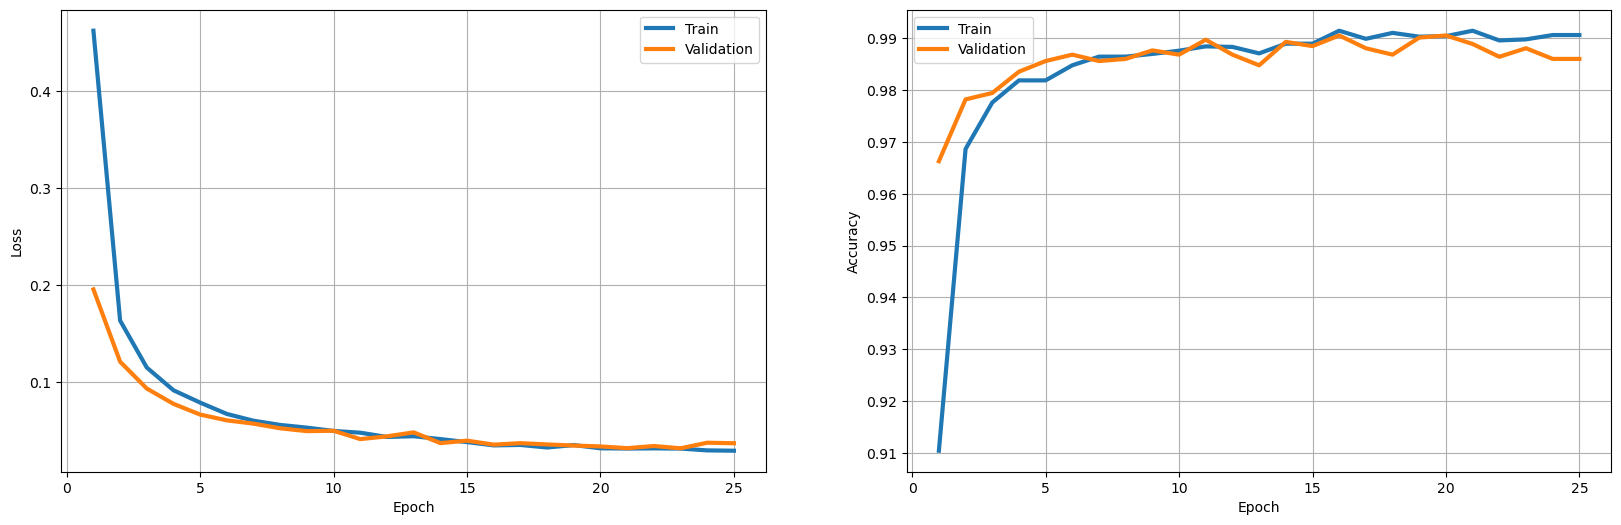

In [ ]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    mobilenetv2_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='mobilenetv2.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

### ResNet50

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'ResNet50'

        self.model = model

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, output_dim)

        for parameter in self.model.fc.parameters():
            parameter.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
resnet50 = models.resnet50(weights="DEFAULT")

resnet50_extract = ResNet50(OUTPUT_DIM, resnet50)

In [ ]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
resnet50_extract = resnet50_extract.to(device)

In [ ]:
summary(resnet50_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
optimizer = optim.Adam(resnet50_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 89.78 s
---------------------------------
Train -- Loss: 0.394, Acc: 92.35%
Val -- Loss: 0.152, Acc: 97.49%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 86.86 s
---------------------------------
Train -- Loss: 0.128, Acc: 97.47%
Val -- Loss: 0.091, Acc: 98.56%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 88.69 s
---------------------------------
Train -- Loss: 0.085, Acc: 98.47%
Val -- Loss: 0.065, Acc: 98.93%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 87.17 s
---------------------------------
Train -- Loss: 0.064, Acc: 98.97%
Val -- Loss: 0.053, Acc: 99.14%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 87.35 s
---------------------------------
Train -- Loss: 0.054, Acc: 99.10%
Val -- Loss: 0.043, Acc: 99.18%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 87.21 s
---------------------------------
Train -- Loss: 0.045, Acc: 99.22%


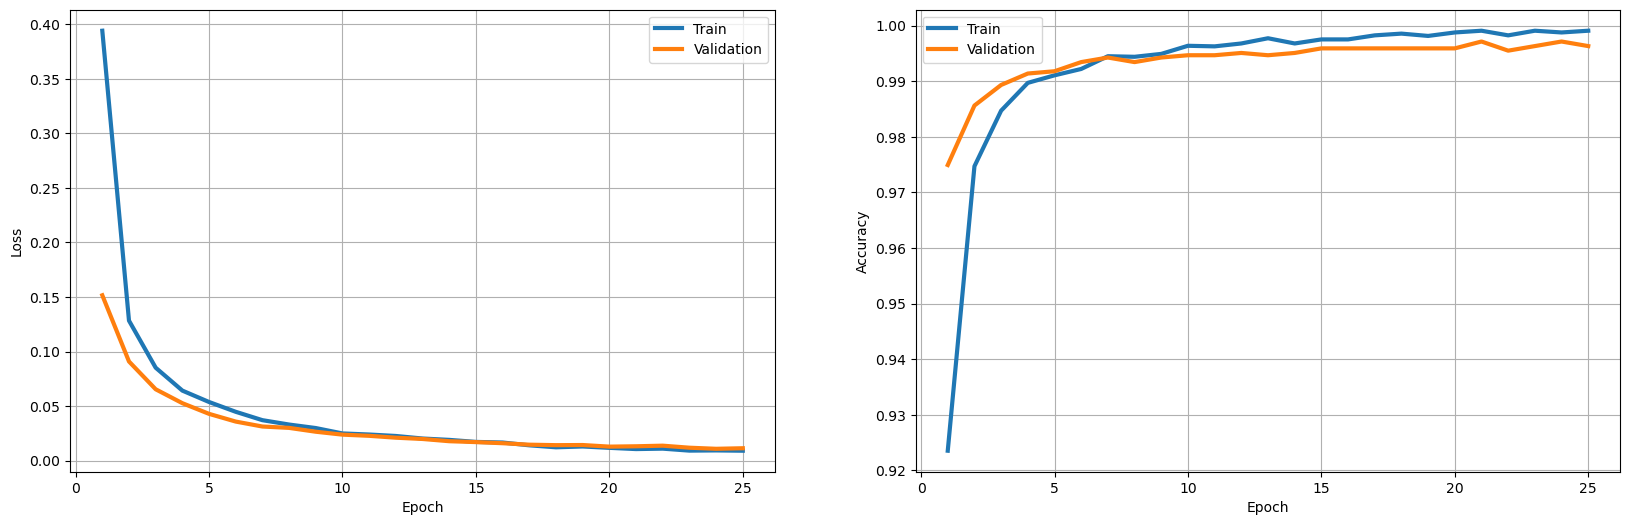

In [ ]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    resnet50_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='resnet50.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

### VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'VGG16'
        
        self.model = model

        # Freeze all "features" layers
        for parameter in self.model.features.parameters():
            parameter.requires_grad = False
        
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
vgg16 = models.vgg16(weights="DEFAULT")

vgg16_extract = VGG16(OUTPUT_DIM, vgg16)

In [ ]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
vgg16_extract = vgg16_extract.to(device)

In [ ]:
summary(vgg16_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
optimizer = optim.Adam(vgg16_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 128.48 s
---------------------------------
Train -- Loss: 0.306, Acc: 90.44%
Val -- Loss: 0.040, Acc: 99.05%

Epoch: 2/25 -- Epoch Time: 126.99 s
---------------------------------
Train -- Loss: 0.217, Acc: 96.97%
Val -- Loss: 0.067, Acc: 98.81%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 130.67 s
---------------------------------
Train -- Loss: 0.200, Acc: 97.72%
Val -- Loss: 0.039, Acc: 99.51%

Epoch: 4/25 -- Epoch Time: 127.91 s
---------------------------------
Train -- Loss: 0.303, Acc: 97.84%
Val -- Loss: 0.113, Acc: 98.85%

Epoch: 5/25 -- Epoch Time: 128.17 s
---------------------------------
Train -- Loss: 0.281, Acc: 98.62%
Val -- Loss: 0.094, Acc: 99.01%

Epoch: 6/25 -- Epoch Time: 128.37 s
---------------------------------
Train -- Loss: 0.220, Acc: 98.89%
Val -- Loss: 0.081, Acc: 99.47%

Epoch: 7/25 -- Epoch Time: 127.48 s
---------------------------------
Train -- Loss: 0.104, Acc: 99.41%
V

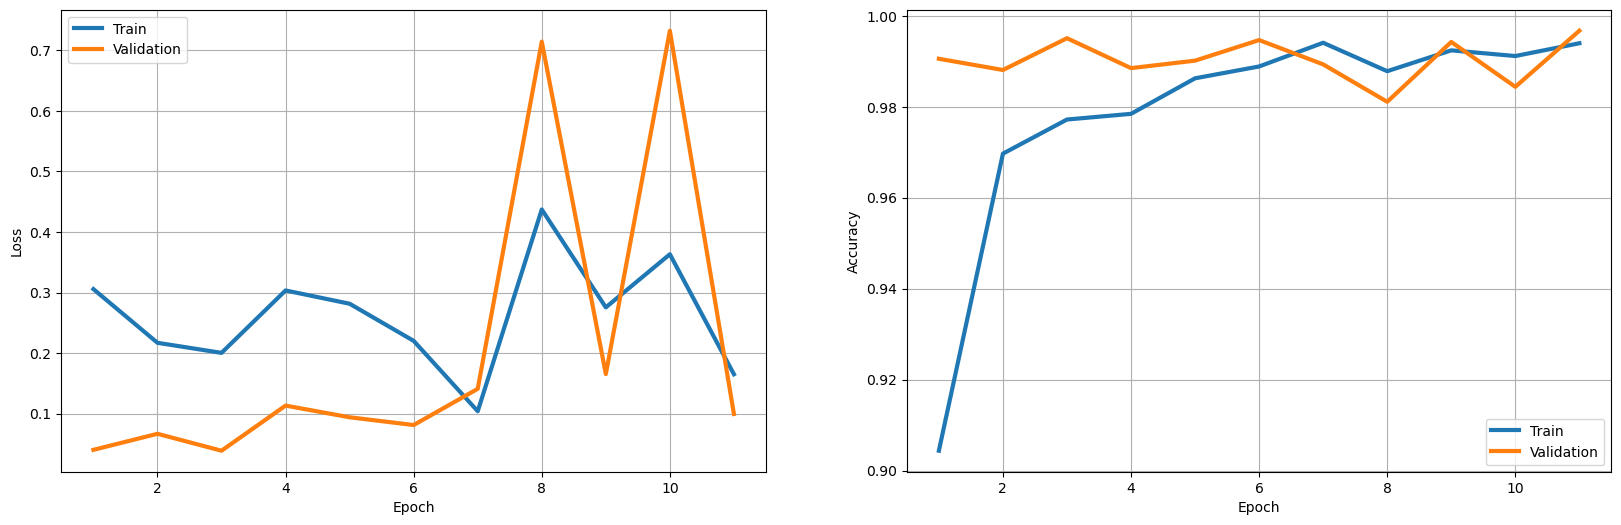

In [ ]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    vgg16_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='vgg16.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

### Testing

In [ ]:
test_loss_baseline_cnn, test_accuracy_baseline_cnn = model_testing(baseline_cnn, test_iterator, criterion, device, model_name='baseline_CNN_cuda.pt')
test_loss_densenet121, test_accuracy_densenet121 = model_testing(dense_net121_extract, test_iterator_imagenet, criterion, device, model_name='dense_net121_cuda.pt')
test_loss_efficientnet_b7, test_accuracy_efficientnet_b7 = model_testing(efficientnet_b7_extract, test_iterator_imagenet, criterion, device, model_name='efficientnet_b7_cuda.pt')
test_loss_mobilenetv2, test_accuracy_mobilenetv2 = model_testing(mobilenetv2_extract, test_iterator_imagenet, criterion, device, model_name='mobilenetv2_cuda.pt')
test_loss_resnet50, test_accuracy_resnet50 = model_testing(resnet50_extract, test_iterator_imagenet, criterion, device, model_name='resnet50_cuda.pt')
test_loss_vgg16, test_accuracy_vgg16 = model_testing(vgg16_extract, test_iterator_imagenet, criterion, device, model_name='vgg16_cuda.pt')

Model name: BaselineCNN
Test -- Loss: 0.018, Acc: 99.41 % 

Model name: DenseNet121
Test -- Loss: 0.028, Acc: 98.98 % 

Model name: EfficientNetB7
Test -- Loss: 0.109, Acc: 95.74 % 

Model name: MobileNetV2
Test -- Loss: 0.041, Acc: 98.28 % 

Model name: ResNet50
Test -- Loss: 0.025, Acc: 99.08 % 

Model name: VGG16
Test -- Loss: 0.068, Acc: 98.65 % 



### Report - Baseline CNN 

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

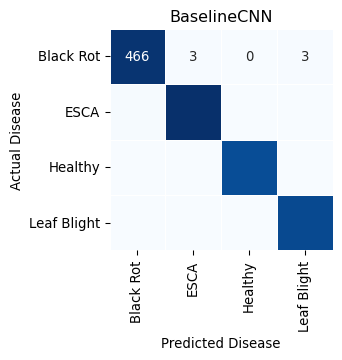


              precision    recall  f1-score   support

   Black Rot       0.99      0.99      0.99       472
        ESCA       0.99      0.99      0.99       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       0.99      1.00      1.00       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



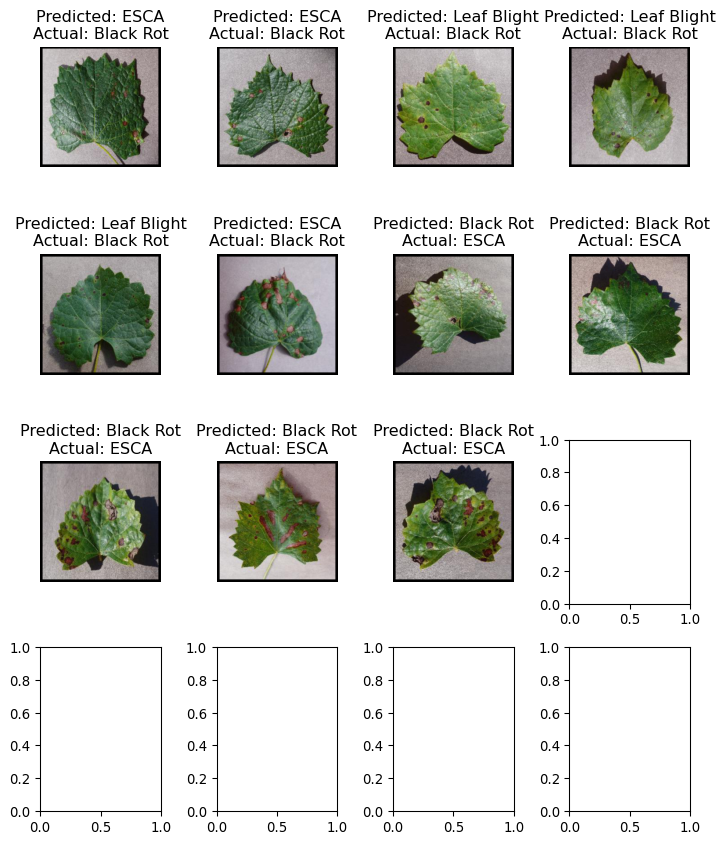

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator and not test_iterator_imagenet (it is not a pretrained model)
print_report(baseline_cnn, test_iterator, device, error_rows=4, error_cols=4)

### Report - DenseNet121

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

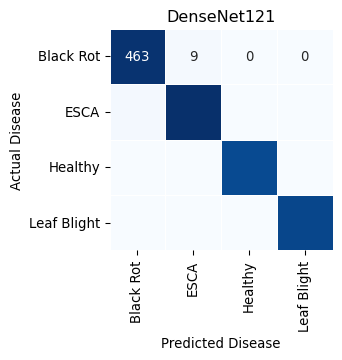


              precision    recall  f1-score   support

   Black Rot       0.98      0.98      0.98       472
        ESCA       0.98      0.98      0.98       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       1.00      1.00      1.00       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



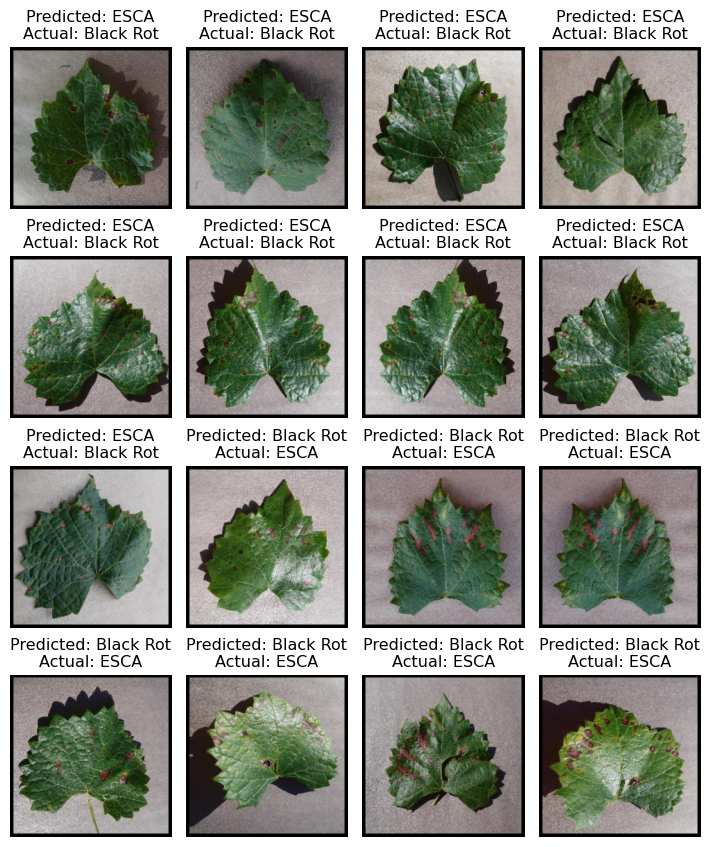

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
print_report(dense_net121_extract, test_iterator_imagenet, device, error_rows=4, error_cols=4)

### Report - EfficientNetB7

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

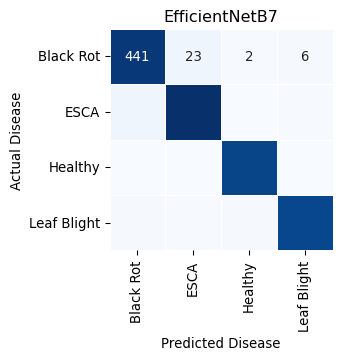


              precision    recall  f1-score   support

   Black Rot       0.94      0.93      0.94       472
        ESCA       0.95      0.95      0.95       480
     Healthy       0.98      1.00      0.99       423
 Leaf Blight       0.98      0.97      0.97       430

    accuracy                           0.96      1805
   macro avg       0.96      0.96      0.96      1805
weighted avg       0.96      0.96      0.96      1805



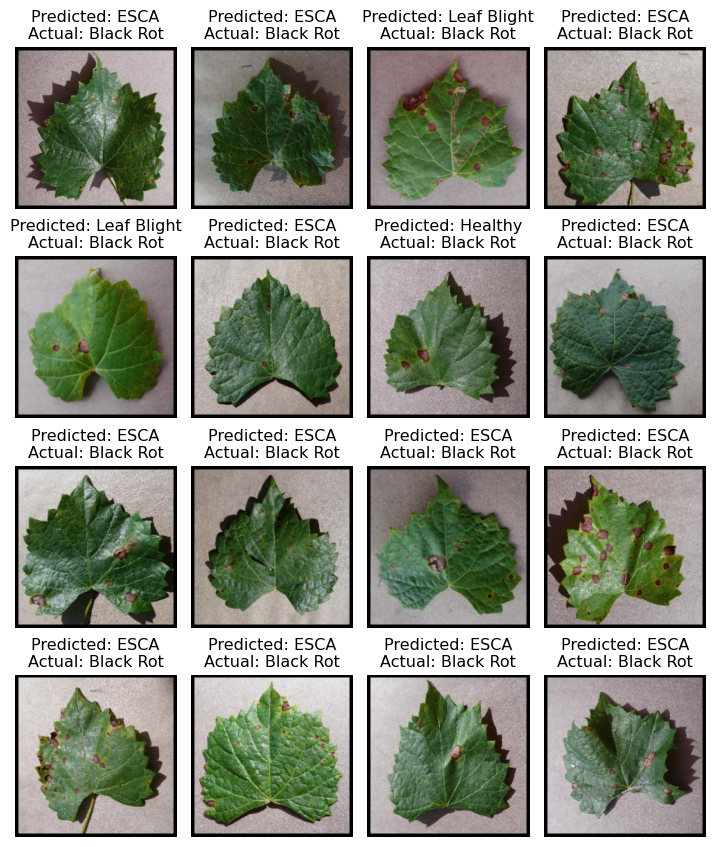

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
print_report(efficientnet_b7_extract, test_iterator_imagenet, device, error_rows=4, error_cols=4)

### Report = MobileNetV2

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

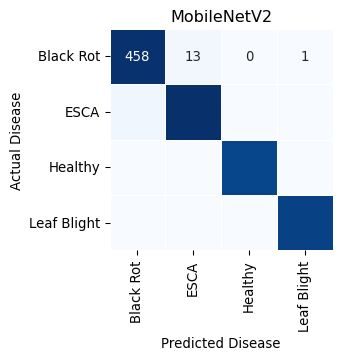


              precision    recall  f1-score   support

   Black Rot       0.96      0.97      0.97       472
        ESCA       0.97      0.96      0.97       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       1.00      1.00      1.00       430

    accuracy                           0.98      1805
   macro avg       0.98      0.98      0.98      1805
weighted avg       0.98      0.98      0.98      1805



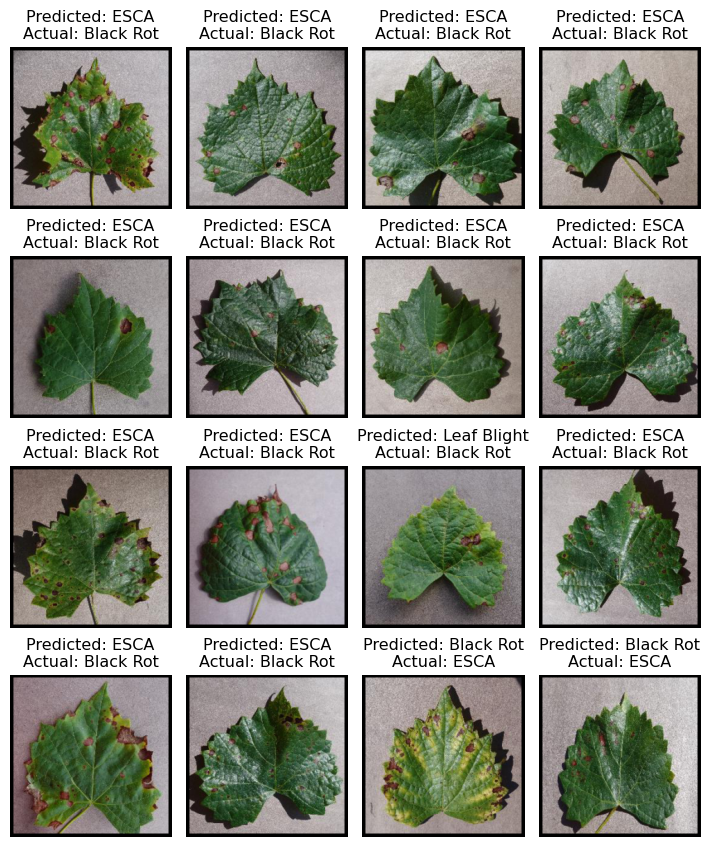

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
print_report(mobilenetv2_extract, test_iterator_imagenet, device, error_rows=4, error_cols=4)

### Report - ResNet50

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

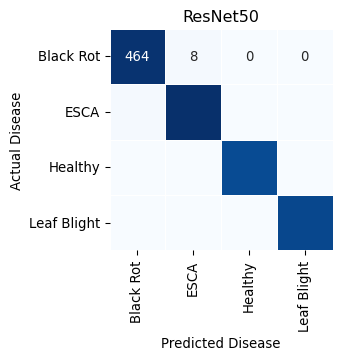


              precision    recall  f1-score   support

   Black Rot       0.98      0.98      0.98       472
        ESCA       0.98      0.98      0.98       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       1.00      1.00      1.00       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



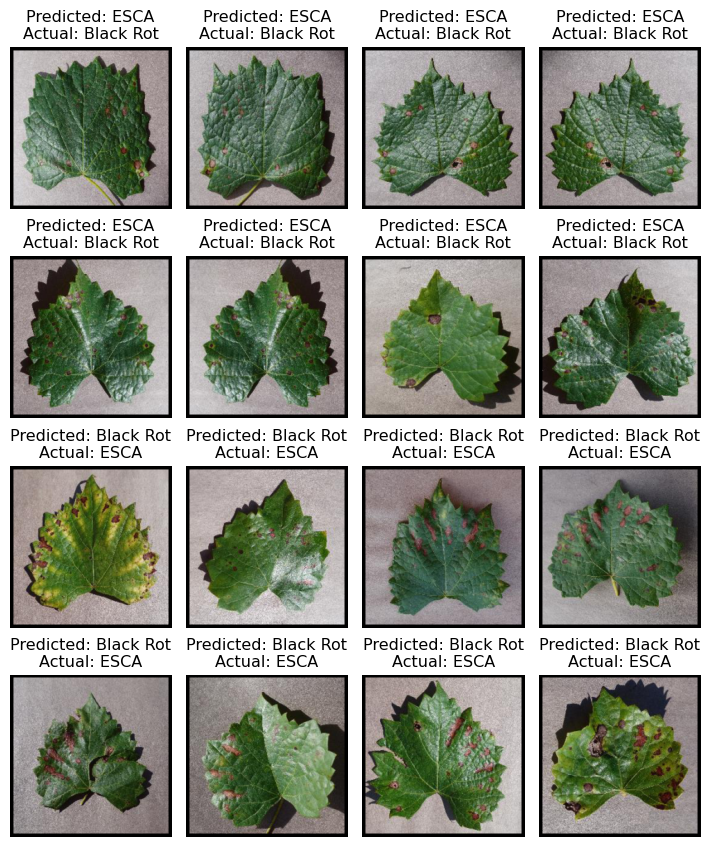

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
print_report(resnet50_extract, test_iterator_imagenet, device, error_rows=4, error_cols=4)

### Report - VGG16

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

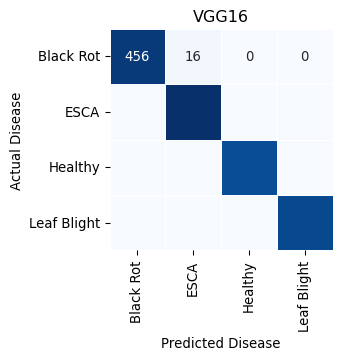


              precision    recall  f1-score   support

   Black Rot       0.99      0.97      0.98       472
        ESCA       0.97      0.99      0.98       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       0.99      1.00      0.99       430

    accuracy                           0.99      1805
   macro avg       0.99      0.99      0.99      1805
weighted avg       0.99      0.99      0.99      1805



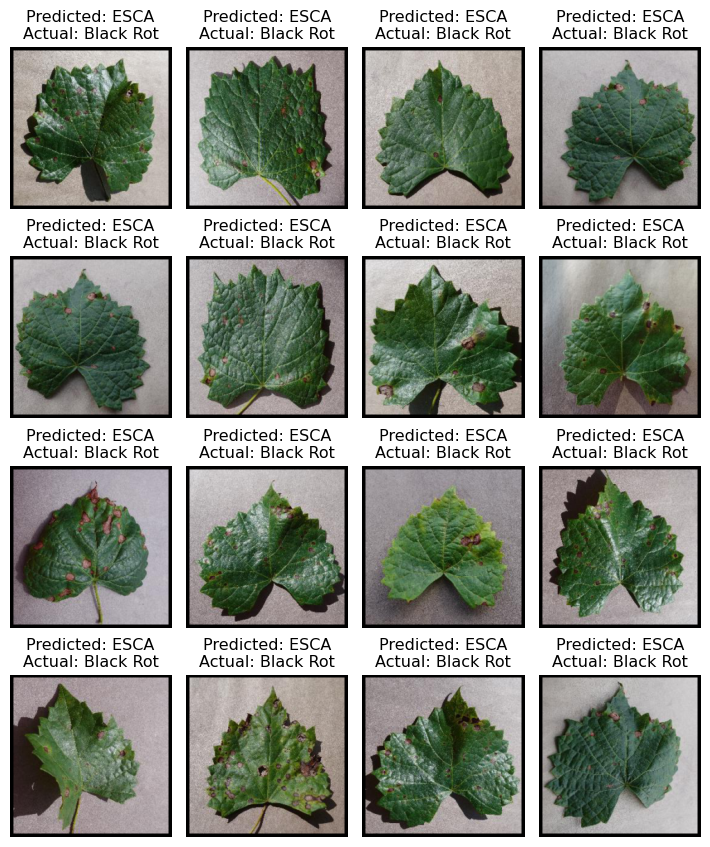

In [ ]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
print_report(vgg16_extract, test_iterator_imagenet, device, error_rows=4, error_cols=4)

### Comparing models

In [ ]:
accuracies = {'Model':['Baseline CNN', 'DenseNet121', 'EfficientNetB7', 'MobileNetV2', 'ResNet50', 'VGG16'],
              'Accuracy':[test_accuracy_baseline_cnn, test_accuracy_densenet121, test_accuracy_efficientnet_b7, test_accuracy_mobilenetv2, test_accuracy_resnet50, test_accuracy_vgg16]}

accuracies = pd.DataFrame(accuracies)
accuracies = accuracies.sort_values('Accuracy',ascending=False)
accuracies

Model  Accuracy
0    Baseline CNN    0.9941
4        ResNet50    0.9908
1     DenseNet121    0.9898
5           VGG16    0.9865
3     MobileNetV2    0.9828
2  EfficientNetB7    0.9574

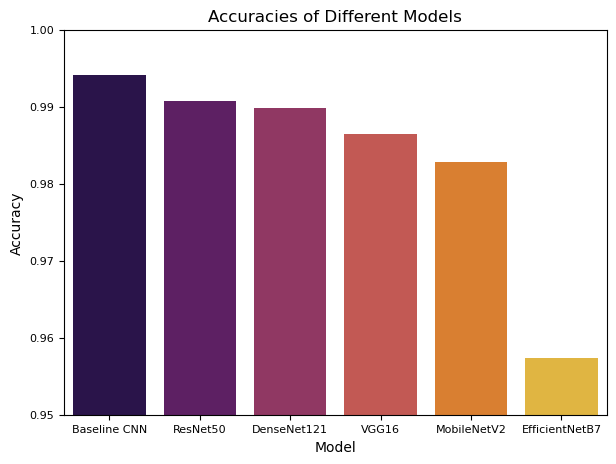

In [ ]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.figure(figsize=(7,5), dpi=100)
plt.title('Accuracies of Different Models')
plt.xticks(rotation=0)
plt.ylim([0.95,1.0])
sns.barplot(data=accuracies, x='Model', y='Accuracy', palette='inferno')
plt.show()

In [ ]:
# model size = Input size + Forward/backward pass size + Params size
model_sizes = {'Model':['Baseline CNN', 'DenseNet121', 'EfficientNetB7', 'MobileNetV2', 'ResNet50', 'VGG16'],
               'Model Size (MB)':[55.06, 5824.16, 1317.47, 161.93, 376.83, 731.57]}

model_sizes = pd.DataFrame(model_sizes)
model_sizes = model_sizes.sort_values('Model Size (MB)', ascending=False)
model_sizes

Model  Model Size (MB)
1     DenseNet121          5824.16
2  EfficientNetB7          1317.47
5           VGG16           731.57
4        ResNet50           376.83
3     MobileNetV2           161.93
0    Baseline CNN            55.06

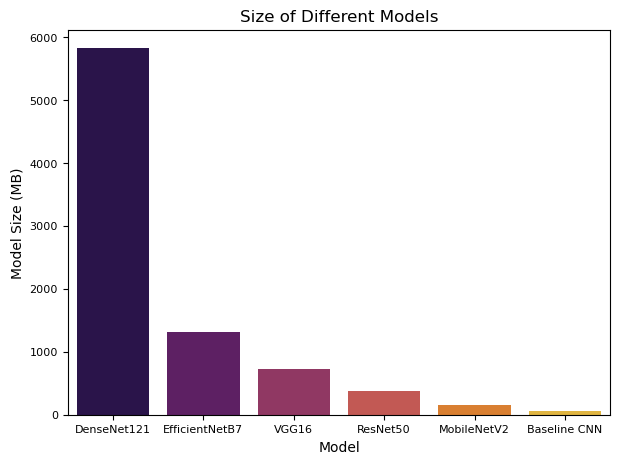

In [ ]:
plt.figure(figsize=(7,5), dpi=100)
plt.title('Size of Different Models')
plt.xticks(rotation=0)
sns.barplot(data=model_sizes, x='Model', y='Model Size (MB)', palette='inferno')
plt.show()

In [ ]:
# model size = Input size + Forward/backward pass size + Params size
model_n_params = {'Model':['Baseline CNN', 'DenseNet121', 'EfficientNetB7', 'MobileNetV2', 'ResNet50', 'VGG16'],
               'Number of parameters':[364580, 6957956, 63797204, 2228996, 23516228, 134276932]}

model_n_params = pd.DataFrame(model_n_params)
model_n_params = model_n_params.sort_values('Number of parameters', ascending=False)
model_n_params['Number of parameters'] = model_n_params['Number of parameters'].apply(lambda x: "{:,}".format(x))
model_n_params

Model Number of parameters
5           VGG16          134,276,932
2  EfficientNetB7           63,797,204
4        ResNet50           23,516,228
1     DenseNet121            6,957,956
3     MobileNetV2            2,228,996
0    Baseline CNN              364,580

In [ ]:
# model size = Input size + Forward/backward pass size + Params size
model_size_accuracy = {'Model Size (MB)':[55.06, 5824.16, 1317.47, 161.93, 376.83, 731.57],
                        'Accuracy':[
                            test_accuracy_baseline_cnn, 
                            test_accuracy_densenet121, 
                            test_accuracy_efficientnet_b7, 
                            test_accuracy_mobilenetv2, 
                            test_accuracy_resnet50, 
                            test_accuracy_vgg16
                            ]
               }

model_size_accuracy = pd.DataFrame(model_size_accuracy)
model_size_accuracy = model_size_accuracy.sort_values('Model Size (MB)', ascending=False)
model_size_accuracy

Model Size (MB)  Accuracy
1          5824.16    0.9898
2          1317.47    0.9574
5           731.57    0.9865
4           376.83    0.9908
3           161.93    0.9828
0            55.06    0.9941

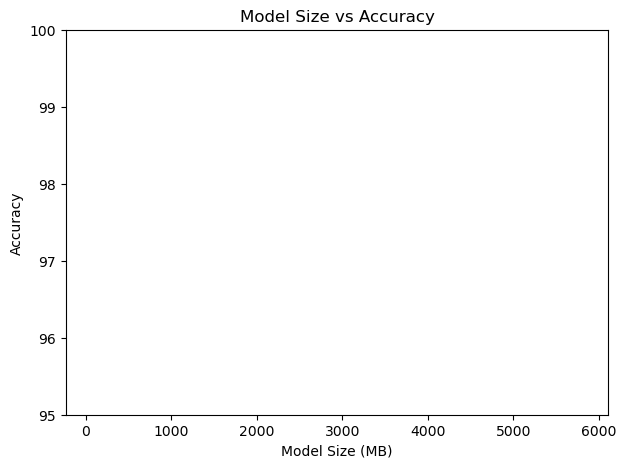

In [ ]:
plt.rcdefaults()

plt.figure(figsize=(7,5), dpi=100)
plt.title('Model Size vs Accuracy')
plt.xticks(rotation=0)
plt.ylim([95,100])
sns.regplot(data=model_size_accuracy, x='Model Size (MB)', y='Accuracy', color='b')
plt.show()

### Max-Voting Ensemble


In [ ]:
true_labels, baseline_CNN_preds= predict(baseline_cnn, test_iterator, device)
_, dense_net121_preds= predict(dense_net121_extract, test_iterator_imagenet, device)
_, resnet50_extract_preds= predict(resnet50_extract, test_iterator_imagenet, device)

In [ ]:
def max_voting_ensemble(pred1, pred2, pred3):
    # Create a tensor of shape [1805, 3]
    concatenated_preds = torch.cat((pred1, pred2, pred3), dim=1)
    
    # Initialize a tensor to store the final ensemble predictions
    ensemble_preds = torch.zeros_like(pred1)
    
    # Iterate over each example
    for i in range(concatenated_preds.size(0)):
        # Count the occurrences of each class for the current example
        class_counts = torch.bincount(concatenated_preds[i].squeeze(), minlength=4)
        
        # Find the class with the maximum count
        max_voted_class = torch.argmax(class_counts)
        
        # Assign the max voted class as the prediction for the current example
        ensemble_preds[i] = max_voted_class
    
    return ensemble_preds

In [ ]:
ensemble_preds = max_voting_ensemble(baseline_CNN_preds, dense_net121_preds, resnet50_extract_preds)

In [ ]:
calculate_accuracy_ensemble(ensemble_preds, true_labels)

0.9939

### Efficiency Test

In [ ]:
start = time.time()

_, baseline_CNN_preds= predict(baseline_cnn, test_iterator, device)
_, dense_net121_preds= predict(dense_net121_extract, test_iterator_imagenet, device)
_, resnet50_extract_preds= predict(resnet50_extract, test_iterator_imagenet, device)
ensemble_preds = max_voting_ensemble(baseline_CNN_preds, dense_net121_preds, resnet50_extract_preds)

end = time.time()

print(f'It takes the max-voting ensemble {round((end-start)/1.805,2)} milliseconds to predict a single image.')

It takes the max-voting ensemble 21.2 milliseconds to predict a single image.
